# 1d polynya growth model

https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/JC092iC07p07049

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape

In [2]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [3]:
Fi = 1 * units('cm/hour')

type(Fi)

pint.Quantity

In [4]:
def xp_over_time_iter(Vi, t, Fi, Hi = 1 * units('m')):

    Xp = np.array([0]) * units('km')
    
#     Xip = np.append(0*units('km'), np.cumsum((Vi[:-1].to(f'km/{time_unit}'))*np.diff(t)))
    
#     Xip = (np.cumsum(Vi.to('km/hour'))).to('km')
    
    for tt in range(len(t)-1):
        
        Xp_tm1 = Xp[-1].to('km')
        
        dt = (t[tt+1] - t[tt]).to('hour')
        dXp = ((Vi[tt] - Xp_tm1 * Fi[tt] / Hi) * dt).to('km')
        
        Xp_t = dXp + Xp_tm1
        
        Xp = np.append(Xp, Xp_t)
        
    return Xp
        
        
    
    
    
def xp_over_time(Vi, t, Fi, Hi = 1 * units('m')):
    
    # Hi : frazil ice collection depth
    
    C = - Vi * Hi / Fi
    Xp = - C * (1 - np.exp(-t * Fi / Hi))
    Xp = Xp.to('km')
    Xip = (Vi*t).to('km')


    return Xp, Xip 




def convert_to_k(T):
    
    if T.units == 'degree_Celsius':
        T = T.to('degree_Kelvin')
    elif T.units == 'delta_degree_Celsius':
        print('T!! should not be delta deg C')
    return T
        
def find_Qlu(Tw, sigma, eo):
    
    Tw = convert_to_k(Tw)
    qlu = sigma * eo * Tw**4
    return qlu.to('W/m2')


def find_Qld(Ta, sigma, ea):
    Ta = convert_to_k(Ta)
    qld = sigma * ea * Ta**4
    return qld.to('W/m2')


def find_Qs(Ta, Tw, rho_a, Cpa, Va):
    
    Ta = Ta.magnitude * units('delta_degree_Celsius')
    Tw = Tw.magnitude * units('delta_degree_Celsius')
    
    Ch = 2e-3 # sensible heat coefficient

    qs = rho_a * Ch * Cpa * Va * (Ta-Tw)
    
    return qs.to('W/m2')


In [5]:

# time_range = slice(datetime(2024,1,2), datetime(2024,1,17))

# time_range = slice(datetime(2019,1,13), datetime(2019,1,25))

# time_range = slice(datetime(2016,1,13), datetime(2016,1,25))

# time_range = slice(datetime(2018,1,1), datetime(2018,1,21))


# time_range = slice(datetime(2016,12,15), datetime(2016,12,28))
# open_years = '2016_2017'


time_range = slice(datetime(2019,1,13), datetime(2019,2,15))
open_years = '2018_2019'

# time_range = slice(datetime(2017,12,22), datetime(2017,12,31))
# open_years = '2017_2018'



# time_range = slice(datetime(2016,12,5), datetime(2016,12,10))


# time_range = slice(datetime(2019,12,7), datetime(2019,12,20))

DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic10_v7.nc')
DS = DS.sel(time = time_range)

DS['length'] = DS['l_max'] #- DS['l_min']

DS['t'] = ((DS.time.values - DS.time.values[0]) / np.timedelta64(1, 's')) * units('s').to('hour')

In [6]:
df2 = pd.read_csv('../data/compiled_stats.csv')

df2['esei'] = vectors.comp_along_theta(df2['ui'], df2['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df2['ese10'] = 0.025*vectors.comp_along_theta(df2['u10'], df2['v10'], 180*units('degree'))* units('m/s').to('km/day')

# manually modify this for now since I set too strict of threshold


In [7]:
ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_{open_years}_v0.nc')
ds.close()

mean_dt = ds.dT.mean('z')
mean_sig = ds.sig0.mean('z')
DT = ds.dT * units('delta_degC')
SIG = ds.sig0 * units('kg/m3')
U = vectors.comp_along_theta(ds.u, ds.v, 145*units('degree'))* units('m/s')

ht_perm3 = cst['Cp_o']*DT*SIG*U
hc_perm3 = cst['Cp_o']*DT*SIG
dz = ds.z.diff('z').values[0] * units('m')

IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

hc_event = hc_perm3.sel(time=time_range)
IHC_event = 0.5*np.sum(hc_event[:-1, :].values + hc_event[1:, :].values, axis=0) *units('joule/m3') * dz



In [24]:
dsc = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_{open_years}.nc')
dsc.close()
dsc = dsc.sel(time=time_range)

dso = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc')
dso.close()
dso = dso.sel(time=time_range)

Tw_sfc = dso.sel(depth=-16).T.values *units('degC')
Tf_sfc = dso.sel(depth=-16).Tf.values *units('degC')


Tw_dma = dso.mean('depth').T.values *units('degC')
Tf_dma = dso.mean('depth').Tf.values *units('degC')
sig0_dma = (dso.mean('depth').sig0.values+1000) *units('kg/m3')



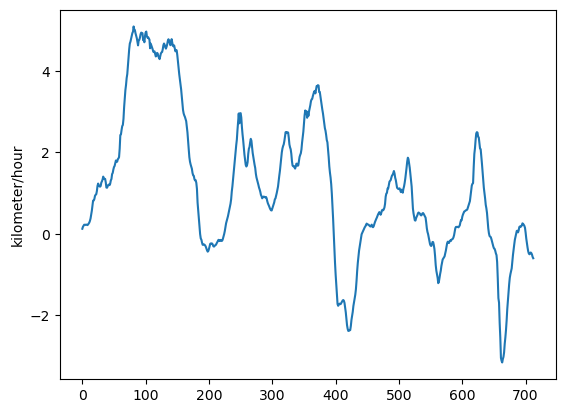

In [38]:
ESE = vectors.comp_along_theta(dsc.u, dsc.v, 145*units('degree')) 
current = ESE.mean('depth').values * units('m/s').to('km/hour')
# plt.plot(ESE.mean('depth')*24)
plt.plot(current)

In [416]:
df = pd.read_csv('/Volumes/Seagate_Jewell/KenzieStuff/met_data/HIYT/herschel-island-yt_fed4_1534_1033.csv')
df = pd.DataFrame(df).set_index('time')
ti = time_range.start.strftime('%Y-%m-%dT%H:%M:%SZ')
tf = time_range.stop.strftime('%Y-%m-%dT%H:%M:%SZ')
date_time_range_df = df.loc[ti:tf]
Ta = date_time_range_df.air_temperature.values.astype(float) * units('degC')
Ua = date_time_range_df.wind_speed.values.astype(float) * units('m/s')

# df_times = pd.to_datetime(date_time_range_df.index)

df_times = np.array([datetime.strptime(datestr, '%Y-%m-%dT%H:%M:%SZ') for datestr in date_time_range_df.index])


Ta, _ = tseries.linear_interpolate(pd.to_datetime(dsc.time.values), df_times, 
                                Ta, max_dt=6*units('hour'))

Ua, _ = tseries.linear_interpolate(pd.to_datetime(dsc.time.values), df_times, 
                                Ua, max_dt=6*units('hour'))

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_90641/2406283450.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Volumes/Seagate_Jewell/KenzieStuff/met_data/HIYT/herschel-island-yt_fed4_1534_1033.csv')


In [10]:
dl = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/hourly_t2m/ERA5_T2m_hourly_{time_range.stop.year}.nc')
Ta = (dl.sel(latitude=70, longitude=-139.75, valid_time = time_range).t2m.values - 273.15) * units('degC')

dw = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc')
dw = dw.sel(latitude=70, longitude=-139.75, time = time_range)
Ua = np.sqrt(dw.u10.values**2+dw.v10.values**2) * units('m/s')

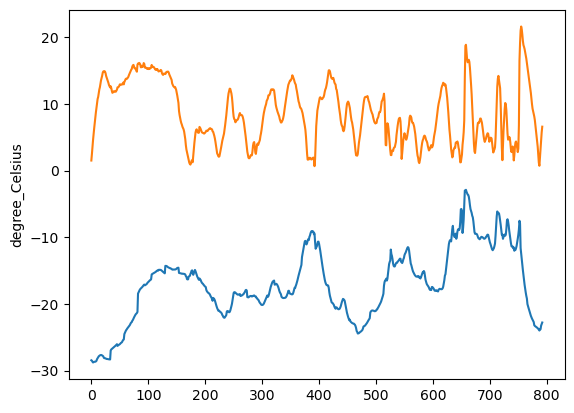

In [11]:
plt.plot(Ta)
plt.plot(Ua.magnitude)

In [131]:

# dT = (Tw_dma[0] - Tf_dma[0]).magnitude * units('delta_degC')
# DQ = dT * (cst['Cp_o']*sigi) * 40 * units('m')


# dTi = - (dQi / (cst['Cp_o'] * sig0_dma[0] * dZ))

# def find_change_ihc(dTi, sig0, dZ, cst):
    
#     # change in heat content
#     d_ihc_dma = cst['Cp_o'] * dTi * sig0 * dZ

#     return d_ihc_dma



In [12]:
def find_dQ(Tw, Ta, Ua, cst):
    
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], Ua)
    # print(Qs)

    Qnet = Qlu + Qld + Qs
    
    return Qnet, Qlu, Qld, Qs

def DT_from_hc(hc, sig0, dZ, cst):
    
    # temperature relative to freezing from heat content
    DT = hc / (cst['Cp_o'] * sig0 * dZ)

    return DT

In [13]:


def find_cooling_time(ihc_dma, Tw_dma, sig0_dma, Tf_dma, 
                      Ta, Ua, cst, dZ,sec_per_hour, TT = 0, duration = 24*7):

    # initial temperature and heat content at this time
    all_hc =  np.array([ihc_dma[TT].magnitude]) * ihc_dma.units
    all_Tw = np.array([Tw_dma[TT].magnitude]) * Tw_dma.units
    isig0 = sig0_dma[TT]
    iTf = Tf_dma[TT]

    all_Qn = np.array([])

    for tt in range(TT, TT+duration):

        # heat balance from air temp and atmos. conditions
        Qnet, Qlu, Qld, Qs = find_dQ(all_Tw[-1], Ta[tt], Ua[tt], cst)
        hourly_dQ = (Qnet * sec_per_hour).to('J/m2')

        all_Qn = np.append(all_Qn, hourly_dQ)

        # new heat content
        nhc = all_hc[-1] - all_Qn[-1]

        # new temperature relative to freezing
        nDT = DT_from_hc(nhc, isig0, dZ, cst)

        # new temp
        nTw = nDT + iTf

        if nTw > iTf:
            all_hc = np.append(all_hc, nhc)
            all_Tw = np.append(all_Tw, nTw)

        else:
            break
            
            
    return len(all_Tw)


In [420]:

# Twater = np.full(len(Tw_dma), -1.75)*units('degC')
# Tfreeze = np.full(len(Tw_dma), -1.8)*units('degC')



Twater = Tw_dma #+ 0.25 * units('delta_degC')
Tfreeze = Tf_dma



dT_dma = (Twater.magnitude - Tfreeze.magnitude) * units('delta_degC')

sec_per_hour = units('hour').to('s')
dZ = 40 * units('m')
ihc_dma = cst['Cp_o'] * dT_dma * sig0_dma * dZ




Qnet, Qlu, Qld, Qs = find_dQ(Twater, Ta, Ua, cst)
Qnet_hourly = Qnet * sec_per_hour

In [ ]:
plt.plot(Qnet)
plt.plot(Qs)
plt.plot(Ua.magnitude*100)
plt.plot((Ta.magnitude+30)*100)

In [429]:


# initial time to start integrating
# #===============
# TT = 4
# #===============


# dT_dma = (Tw_dma.magnitude - Tf_dma.magnitude) * units('delta_degC')


total_T = np.array([])
total_dist = np.array([])


for TT in range(24*18):
    
#     T = find_cooling_time(ihc_dma, Tw_dma, 
#                           sig0_dma, Tf_dma, Ta , Ua, cst, dZ, TT = TT)
    
    T = find_cooling_time(ihc_dma, Twater, 
                          sig0_dma, Tfreeze, Ta, Ua, cst, dZ, sec_per_hour, TT = TT, duration = 24*6)

    total_T = np.append(total_T, T)
    
    dist = np.sum(ESE.mean('depth')[TT:TT+T])
    total_dist = np.append(total_dist, dist)


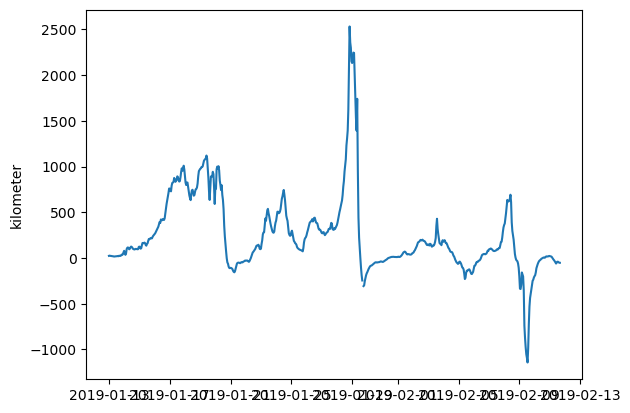

In [430]:
cooling_time = (ihc_dma/Qnet).to('hour')
# plt.plot(dso.time, current*cooling_time)

plt.plot(dso.time, current*cooling_time)
# plt.plot(dso.time[:24*5], current[:24*5].magnitude*total_T)
# plt.bar(DS.time, DS.length.values*units('km'))
# plt.ylim(-100,1500)

In [431]:
# daily_t = np.array([])
# daily_v = np.array([])

# for ii in np.arange(0,len(total_T),24):
#     daily_t = np.append(daily_t, np.mean(total_T[ii:ii+24]))
#     daily_v = np.append(daily_v, np.mean(ESE.mean('depth').values[:24*5][ii:ii+24])*units('m/s').to('km/hour'))
    

In [432]:
hourly_flow = current.to('km/hour').magnitude
daily_transport = np.array([np.sum(hourly_flow[ii:ii+24]) for ii in range(len(hourly_flow))])

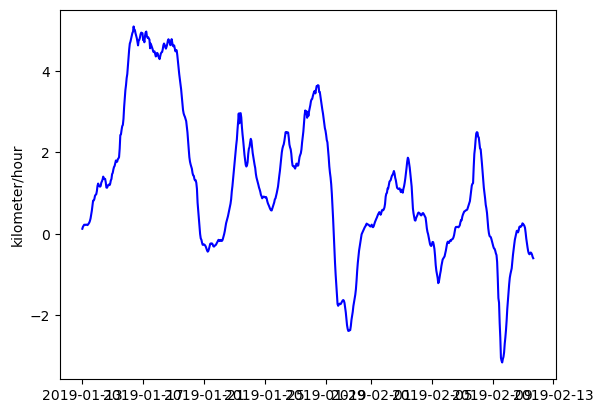

In [40]:
plt.plot(dso.time, current, c='b', label='current')

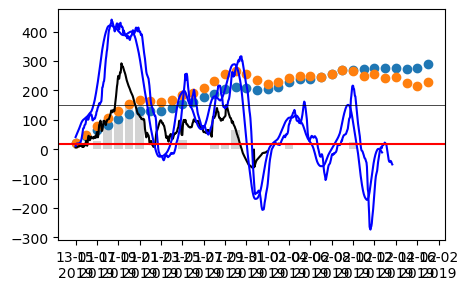

In [433]:
# plt.plot(dso.time[:24*5], total_T)
fig, ax = plt.subplots(figsize=(5,3))

plt.plot(dso.time[:24*18], total_dist, c='k', label='estimated cooling distance')
plt.plot(dso.time, current.to('km/day').magnitude, c='b', label='current')
plt.plot(dso.time, daily_transport, c='b', label='current')


plt.axhline(18, label='Pease stable length (adjust )', c='r')

plt.bar(DS.time, DS.length, color='lightgray', zorder=-1)

# plt.bar(dso.time[:24*5][::24], (daily_v*daily_t), color='r', zorder=-1, alpha=0.5)

# plt.xlim(datetime(2019,1,12), datetime(2019,1,22))
# plt.legend(bbox_to_anchor = (1,1))

# plt.scatter(DS.time, np.cumsum(df2[4732:4748].esei.values))
# plt.scatter(DS.time, np.cumsum(df2[4732:4748].ese10.values))

converted_times = pd.to_datetime(df2.time.values)
time_cond = (converted_times >= DS.time.values[0]) & (converted_times <= DS.time.values[-1])

plt.scatter(DS.time, np.cumsum(df2[time_cond].esei.values))
plt.scatter(DS.time, np.cumsum(df2[time_cond].ese10.values))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)



plt.axhline(150, c='k', lw=0.5)

In [ ]:
all_max_angles = np.array([])
all_angles = np.array([])


years = [2023, 2024]


for year in years:
    
    with xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v7.1.nc') as ds:
        
        all_max_angles = np.append(all_max_angles, ds.max_length_direction.values[ds.max_length>0])

# ds.max_length.plot(marker='.')
# # ds.max_length_direction.plot()
# ds.l_max.plot(marker='.')

In [1]:
fig, ax = plt.subplots(figsize=(3,3))
plt.hist(all_max_angles, bins=np.arange(0,190,5))
# plt.hist(all_angles, bins=np.arange(0,190,5))


NameError: name 'plt' is not defined

ValueError: x and y must be the same size

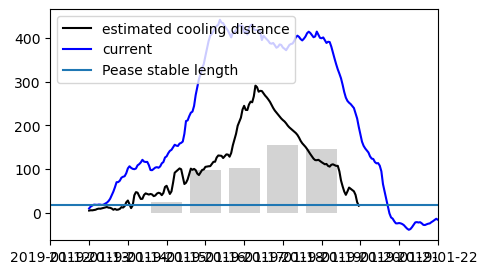

In [116]:
# plt.plot(dso.time[:24*5], total_T)
fig, ax = plt.subplots(figsize=(5,3))

plt.plot(dso.time[:24*7], total_dist, c='k', label='estimated cooling distance')
plt.plot(dso.time, current.to('km/day').magnitude, c='b', label='current')
# plt.plot(dso.time, daily_transport, c='b', label='current')


plt.axhline(18, label='Pease stable length')

plt.bar(DS.time, DS.length, color='lightgray', zorder=-1)

plt.xlim(datetime(2019,1,12), datetime(2019,1,22))
plt.legend()

plt.scatter(DS.time, np.cumsum(df2[4732:4745].esei.values))
plt.scatter(DS.time, np.cumsum(df2[4732:4745].ese10.values))

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
date_fmt = mdates.DateFormatter('%d-%m\n%Y')
ax.xaxis.set_major_formatter(date_fmt)

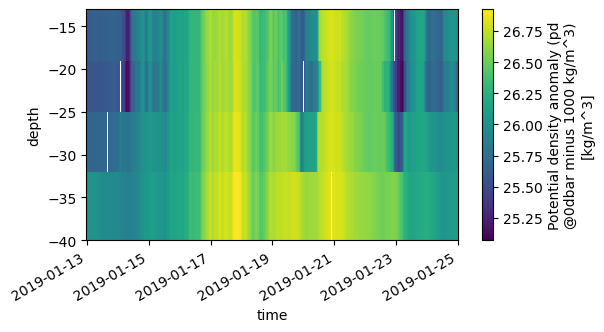

In [795]:
fig, ax = plt.subplots(figsize=(6,3))
dso.sig0.plot()

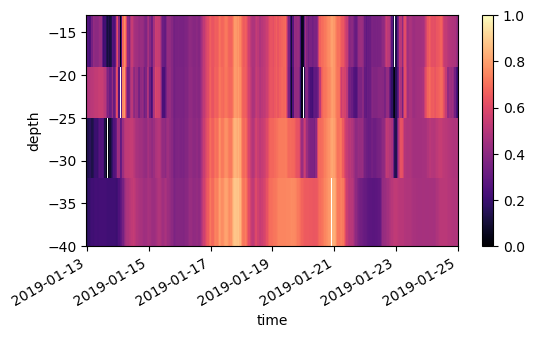

In [840]:
fig, ax = plt.subplots(figsize=(6,3))
# ((dso.Ct - dso.Tf)-(dso.Ct - dso.Tf).sel(depth=-16)).plot(vmin=-0.25, vmax=0.25, cmap='RdBu_r')

((dso.Ct - dso.Tf)).plot(vmin=0, vmax=1, cmap='magma')

In [ ]:
date_fmt = mdates.DateFormatter('%d-%m-%Y')

In [580]:
np.cumsum(df2[4732:4745].esei.values)

array([ 20.99532449,  44.63069102,  63.49488576,  80.84948943,
        99.87842714, 117.82514556, 125.79207366, 125.80374687,
       130.53442653, 141.11425706, 155.13253204, 164.59685351,
       182.25209411])

In [576]:
np.cumsum(df2[4732:4745].esei.values)

array([ 20.46574238,  43.15525686,  63.56465984,  82.93892507,
       102.95725921, 121.00042964, 128.25686123, 128.69426734,
       130.89216318, 140.52581794, 152.51333609, 160.67827094,
       175.88568555])

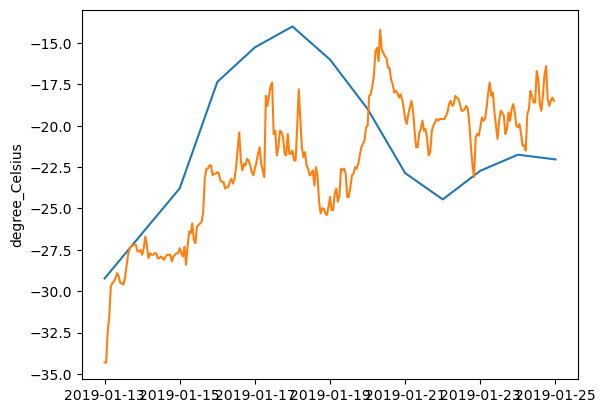

In [443]:
dss = xr.open_dataset('../data/forcing/regional_daily_era_2019_v7_witht2m.nc')
dss = dss.sel(time=time_range)

# plt.plot(dss.time, np.sqrt(dss.u10**2+dss.v10**2))
# plt.plot(dso.time[:-1], Ua)

plt.plot(dss.time, dss.t2m)
plt.plot(dso.time[:-1], Ta)

In [452]:
dsc

<xarray.Dataset>
Dimensions:  (depth: 10, time: 289)
Coordinates:
  * depth    (depth) float64 -30.0 -24.0 -22.0 -18.0 ... -10.0 -8.0 -6.0 -4.0
  * time     (time) datetime64[ns] 2019-01-13 2019-01-13T01:00:00 ... 2019-01-25
Data variables:
    u        (depth, time) float64 -0.02233 -0.02332 ... -0.2566 -0.2468
    v        (depth, time) float64 -0.01361 -0.01187 -0.006635 ... 0.1792 0.1477
Attributes:
    lat:      69.7718
    lon:      -139.2582

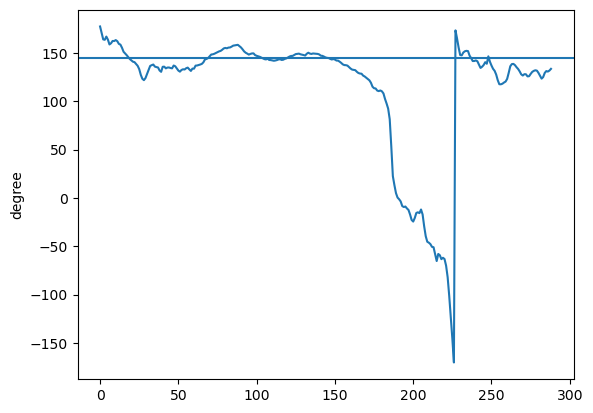

In [451]:
plt.plot(vectors.vector_angle(dsc.u.mean('depth').values, dsc.v.mean('depth').values))

plt.axhline(145)

In [444]:
fig, axs = fn.makemap(view='narrowzoom', contours = [-400,-300,-200,-100], figsize=(4,6), panels=(2,1))

for ax in axs:
    line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
    for lat in [69,71,73]:
        ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
    for lon in [-160,-150,-140,-130]:
        ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)



NameError: name 'fn' is not defined

In [ ]:
plt.plot(dss.time[:-1], Ua)

In [429]:
len(np.cumsum(df2[4732:4747].esei.values))

15

array(['2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
       '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
       '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
       '2019-01-25'], dtype=object)

In [425]:
len(DS.time)

13

In [426]:
np.cumsum(df2[4732:4747].esei.values)

array([ 20.99532449,  44.63069102,  63.49488576,  80.84948943,
        99.87842714, 117.82514556, 125.79207366, 125.80374687,
       130.53442653, 141.11425706, 155.13253204, 164.59685351,
       182.25209411, 195.0465793 , 210.20145829])

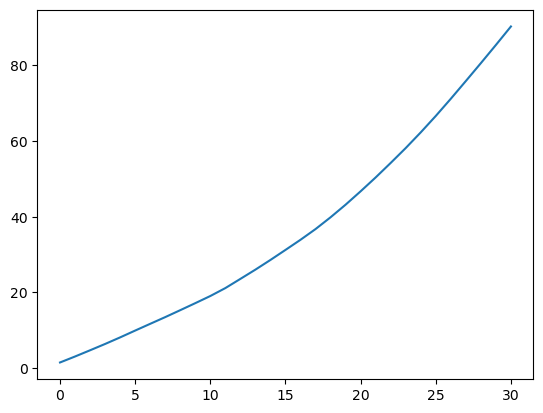

In [320]:
plt.plot(np.cumsum(ESE.mean('depth')[TT:TT+len(all_Tw)]))

In [307]:
dso

<xarray.Dataset>
Dimensions:  (depth: 4, time: 145)
Coordinates:
  * depth    (depth) float64 -36.0 -28.0 -22.0 -16.0
  * time     (time) datetime64[ns] 2019-01-15 2019-01-15T01:00:00 ... 2019-01-21
Data variables:
    T        (depth, time) float64 -1.337 -1.346 -1.359 ... -1.04 -1.037 -1.057
    Sp       (depth, time) float64 32.41 32.43 32.45 32.45 ... 33.36 33.35 33.32
    Sa       (depth, time) float64 32.57 32.59 32.6 32.6 ... 33.52 33.51 33.48
    Ct       (depth, time) float64 -1.33 -1.34 -1.353 ... -1.034 -1.032 -1.051
    Tf       (depth, time) float64 -1.796 -1.797 -1.798 ... -1.835 -1.834 -1.833
    sig0     (depth, time) float64 26.07 26.09 26.1 26.1 ... 26.83 26.82 26.8
Attributes:
    lat:      69.7718
    lon:      -139.2582

In [306]:
len(all_Tw)

31

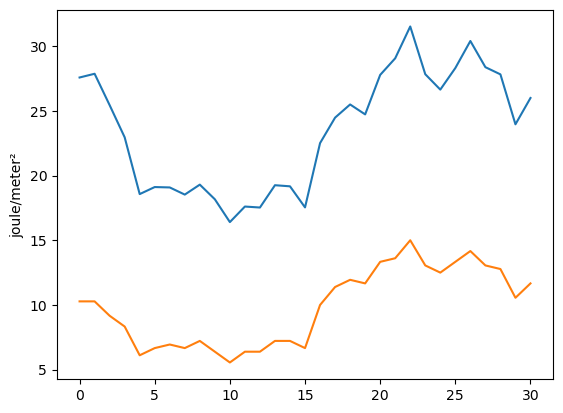

In [305]:
# plt.scatter(np.diff(all_Tw.magnitude), Ua[:12].magnitude)
plt.plot(all_Qn/10e4)
plt.plot(Ua.magnitude[:len(all_Qn)])
# plt.plot(all_hc)

In [279]:
np.diff(all_Tw.magnitude)

array([-0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544, -0.0174544,
       -0.0174544, -0.0174544, -0.0174544, -0.0174544])

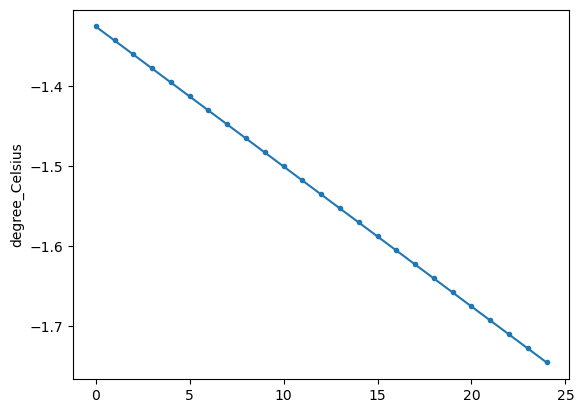

In [282]:
plt.plot(all_Tw, marker='.')

# plt.plot(Ua[:12].magniutde, marker='.')

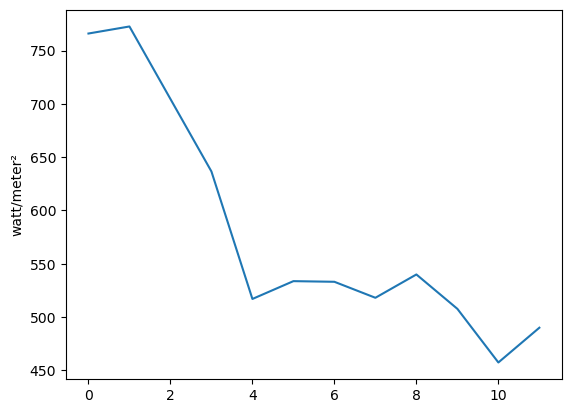

In [257]:
plt.plot(all_Qn)
plt.plot(all_Qn)

<Quantity(-1.30855472, 'degree_Celsius')>

In [214]:
d_ihc_dma = find_change_ihc(sig0_dma[0], dZ, cst)

In [215]:
ihc_dma[0] + d_ihc_dma

<Quantity(69590742.5, 'joule / meter ** 2')>

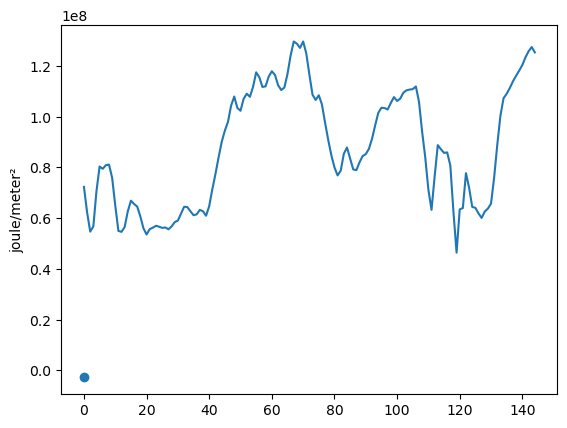

In [202]:
plt.plot(ihc_dma)
plt.scatter(0,d_ihc_dma)

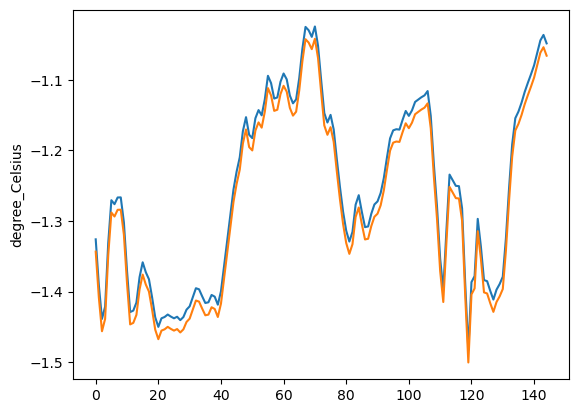

In [195]:
plt.plot(Tw_dma)
plt.plot(Tw_dma+dTi)

In [153]:
dT

<Quantity(0.457882152, 'delta_degree_Celsius')>

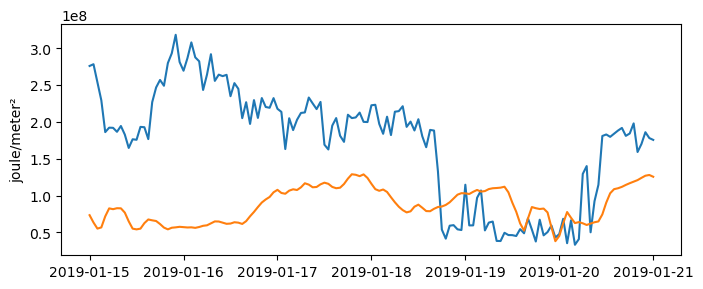

In [151]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(dso.time, hourly_dQ*100)
plt.plot(dso.time, IHC_event)
# plt.plot(dso.time, Qs)

In [94]:
hourly_dQ = (dQ * sec_per_hour).to('J/m2')

In [ ]:
Tf = -17.5 * units('')

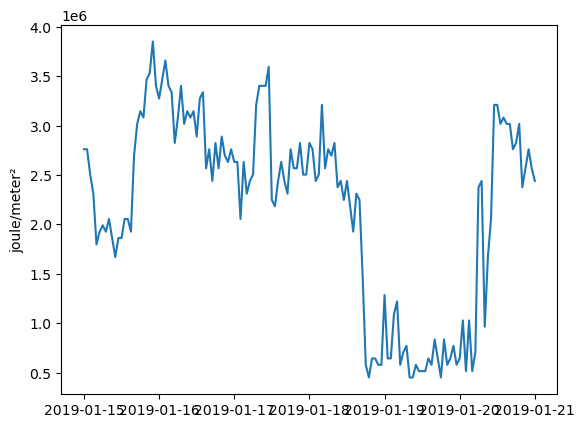

In [95]:
# plt.plot(hc_event.time, hourly_dQ)
# plt.plot(hc_event.time, IHC_event)

plt.plot(hc_event.time, hourly_dQ)
# plt.plot(hc_event.time, IHC_event)

In [80]:
IHC_event

Magnitude,[73464953.87178077 63512764.218427576 55264951.846704565 56867129.583454266 71857433.77226585 82681411.81889516 81603635.6209674 82902026.47212096 82747707.44034642 76947935.50859377 65098245.590497345 55188976.7875576 54208991.41985109 55214713.93016813 62657373.20368467 67638394.63158894 66486248.83436458 65540952.52850595 61447197.730541736 56635924.78289066 54229270.47237523 56440303.57756666 56951293.788991004 57672718.86294079 57235142.89497396 56793541.028210714 56975061.482418634 56271959.09454789 57418818.3447804 59046528.439356565 59736223.113298744 62457018.52993647 65009373.30210496 64871240.714982525 63295583.6343139 61749526.42521414 62101029.07177925 63871064.32450052 63335129.34204152 61574941.450474724 65357090.8199728 71973354.94249946 77870039.01388761 84461852.23079018 90616110.75665088 94794654.3862729 98178302.20218538 104484452.75404884 107822152.89641383 103583735.93653637 102516528.84720172 106721514.39356413 108556769.20959601 107589131.3075899 111210589.1902986 116720602.92554164 114920225.57988621 111295347.50862932 111690296.18270636 115284347.16700627 117529810.3031412 115997383.54670417 111785561.53649488 110007348.78110088 110714119.28263178 115718625.9208656 123014843.31768967 128938282.77153547 128230570.14942312 126387437.00076243 128770147.17796588 123935911.47953367 116022402.93525647 108749405.76146793 106522600.50536802 108269790.61644085 104954136.54796854 97775937.19571376 90951451.59963787 84932006.21763657 80327769.42068817 77228303.38313322 78681650.6735008 84958669.06628501 87724786.07860342 83557370.7727497 79037685.3942834 78830722.46480364 82110541.23285143 84546540.3695416 85224667.28401095 87329735.33991405 90941444.8893111 96161833.48447327 101255921.70383738 103286518.2071654 103048550.16406693 102181706.2814856 105169010.20408571 107667674.35081315 105426662.40829307 106150634.9210813 108865732.89566752 109968718.9145184 110309657.70149602 110802025.34691553 112028260.19133157 104488067.73409148 90469455.35571785 78138317.09223239 62278086.26491126 52522809.56968214 68980104.11194174 84482478.259117 82910160.11601228 81824560.9158362 82430465.29372749 77203617.35894683 56933248.86311151 38188654.92182082 45259279.03479096 62402897.26891743 77729844.41864339 69917688.5956626 62763936.764245465 64063484.320092455 62453563.13582227 60171423.59319905 62117004.702261776 63881454.413627625 64963745.617005214 74510709.98849586 90478458.43333045 103157744.23205772 108750017.18070489 109951249.33723113 111879873.3958075 114501810.52211109 116821863.31019408 118861005.05636035 121006913.16594817 124081205.61575174 126972967.10822064 127969337.26597357 125564471.4153453]
Units,joule/meter2


In [ ]:
ht_perm3

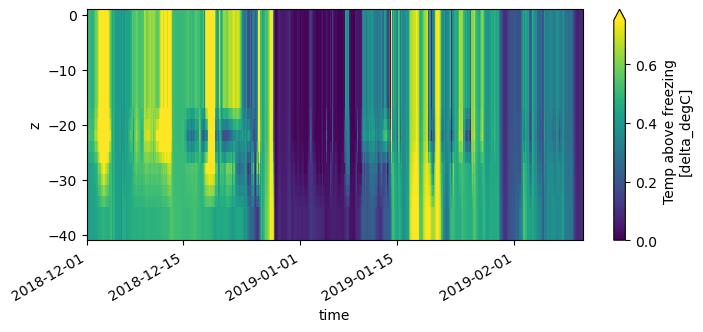

In [18]:
fig, ax= plt.subplots(figsize=(8,3))
ds.dT.plot(vmin=0, vmax=0.75)

In [43]:
Ta[0]

<Quantity(-27.4, 'degree_Celsius')>

In [72]:
=

<Quantity(-1.28455998, 'degree_Celsius')>

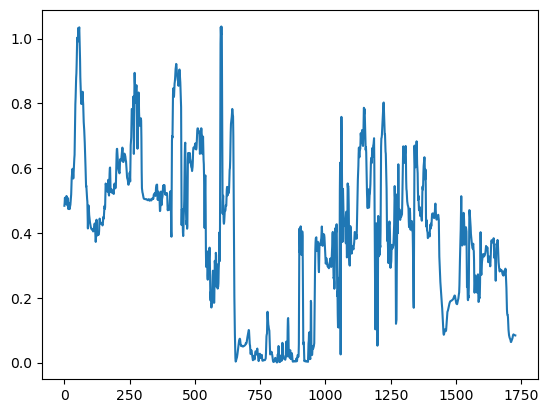

In [31]:
plt.plot(ds.dT.sel(z=0))

In [19]:
dsp = xr.open_dataset(f'../data/forcing/regional_hourly_era_{time_range.stop.year}_v6.nc')
dsp = dsp.sel(time = time_range)

Va = vectors.comp_along_theta(dsp.u10.values, dsp.v10.values, 145*units('degree')) * units('m/s')
Vap = vectors.comp_along_theta(dsp.u10.values, dsp.v10.values, (145-90)*units('degree')) * units('m/s')

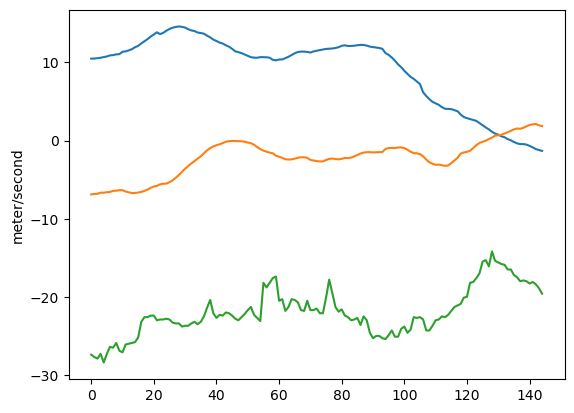

In [20]:
plt.plot(Va)
plt.plot(Vap)
plt.plot(Ta.magnitude)

In [21]:
# polynya length



# Va = 20 * units('m/s')

# Vi = 30 * units('cm/s') # rate of pack ice advection from shore
Vi = 0.035 * Va

Fi = 1 * units('cm/hour') # ice production rate

Hi = 1 * units('m') # frazil ice collection depth

# t = np.arange(0, 360) * units('hour')

t = np.arange(0, len(Vi)) * units('hour')




NameError: name 'Tw' is not defined

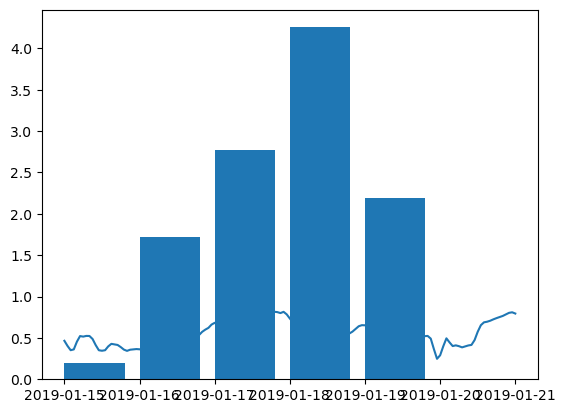

In [22]:
plt.plot(dsp.time, mean_dt.sel(time = time_range))
plt.bar(DS.time, DS.extent/1000, align='edge')
plt.plot(dsp.time, Tw)

In [122]:
Qn = find_dQ(Tw, Ta, Ua)

In [123]:
HC_i - dQ

<Quantity(63335856.5, 'joule / meter ** 2')>

In [134]:
dQ

<Quantity(1800000.0, 'joule / meter ** 2')>

In [54]:
dT = (Twi - Tf).magnitude * units('delta_degC')
DQ = dT * (cst['Cp_o']*sigi) * 40 * units('m')

NameError: name 'Twi' is not defined

In [196]:
(DQ/Qi).to('hour')

<Quantity(36.3455648, 'hour')>

In [171]:
(cst['Cp_o'])

<Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>

In [129]:
dQ/(cst['Cp_o'] * sigi)

<xarray.DataArray 'sig0' ()>
<Quantity(0.455679988, 'delta_degree_Celsius / meter ** 2')>

In [67]:
# initial values
Tf = -1.8 *units('delta_degC')
Twi = np.mean((mean_dt.sel(time = time_range).values+Tf.magnitude)[:12])*units('degC')
sigi = np.mean(mean_sig.sel(time=time_range)[:12]).values * units('kg/m3')
HC_i = np.nanmean(IHC_event[:12])


In [70]:
dt = (1*units('hour').to('s'))
dh = int(dt.to('hour').magnitude)
DZ = 40*units('m')
rho_a = cst['rho_a']


In [80]:
Twi

<Quantity(-1.35244032, 'degree_Celsius')>

In [81]:
Hc = [HC_i]
Tw = [Twi]
# Ua = [np.nanmean(Va[ii*dh:(ii+1)*dh])]
Ua = [Va[0]]
t = [0]

for ii in range(0,32):

    Qt = find_dQ(Tw[-1], Ta[ii], Ua[-1])
    dQ = (Qt * dt).to('J/m2')

    # find cooling rate 
    dTdt = -dQ/((cst['Cp_o']*sigi) * DZ)

    # save new Hc
    Hc.append(Hc[-1] - dQ)
    # save new temp
    Tw.append((Tw[-1].magnitude + dTdt.magnitude) * units('degree_Celsius'))
    # next wind
    Ua.append(np.nanmean(Va[ii*dh:(ii+1)*dh]))
    
    t.append(t[-1] + dt.to('hour').magnitude)

In [87]:
HC_i

<Quantity(70678097.7, 'joule / meter ** 2')>

In [82]:
uu = [U.magnitude for U in Ua]
hhcc = [H.magnitude for H in Hc]
tw = [T.magnitude for T in Tw]

In [83]:
len(t)

33

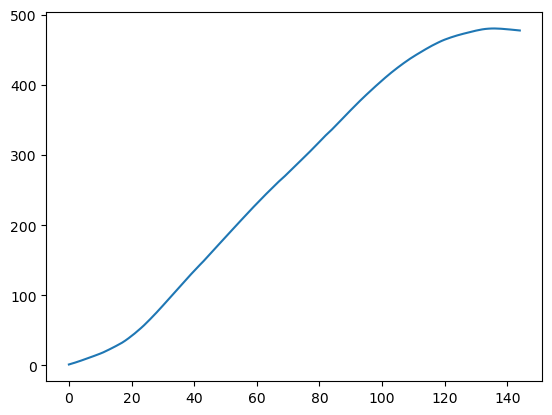

In [84]:
dtt = (((U.sel(time=time_range).time - U.sel(time=time_range).time[0]).values / np.timedelta64(1,'h')))
advection = (np.cumsum(U.sel(time=time_range).mean('z') * 1 * units('hour').to('s'))/1000) * units('km')
plt.plot(dtt, advection)

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_22393/2696151833.py:5: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Water parcel T ($^{\circ}$C)', c='b')


Text(0, 0.5, 'Par0cel transport (km)\nalong shelf current')

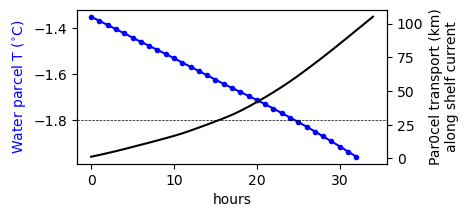

In [86]:
fig, ax = plt.subplots(figsize=(4,2))
# plt.plot(uu)
# plt.plot(t,hhcc)
plt.plot(t, tw, marker='.', c='b')
ax.set_ylabel('Water parcel T ($^{\circ}$C)', c='b')
plt.axhline(Tf, lw=0.5, ls='dashed', c='k')
plt.xlabel('hours')

ax2 = ax.twinx()
ax2.plot(dtt[:35], advection[:35], c='k')
ax2.set_ylabel('Par0cel transport (km)\nalong shelf current')



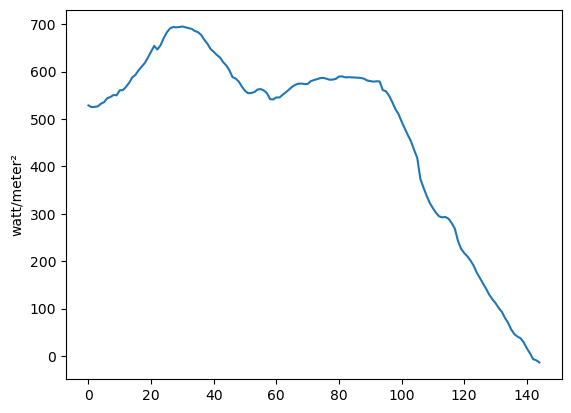

In [93]:
# plt.plot(Qlu+Qld)
# plt.plot(Qs)
plt.plot(Qnet)

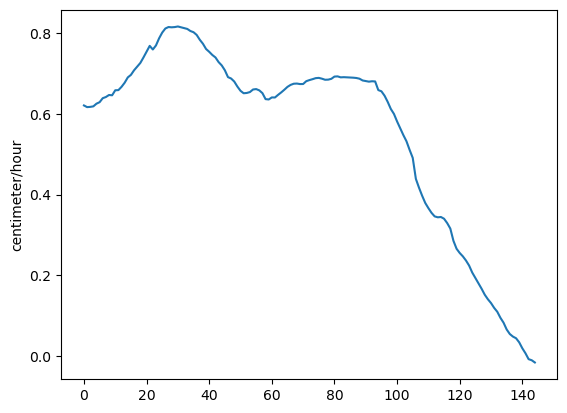

In [80]:

# for now, ignore evaporative latent heat flux, and shortwave radiation for winter

Ta = -17 * units('degC')
rho_a = cst['rho_a']

Tf = -1.8 *units('delta_degC')
Tw = -1.8 * units('degC')



# define positive upward
Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
Qs = -find_Qs(Ta, Tw, rho_a, cst['Cp_a'], Va)
# print(Qs)

Qnet = Qlu + Qld + Qs

dHdt = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')

plt.plot(dHdt)

<BarContainer object of 193 artists>

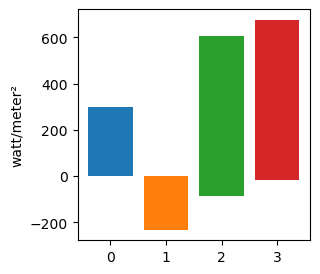

In [48]:
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(0, Qlu)
plt.bar(1, Qld)
plt.bar(2, Qs)
plt.bar(3, Qnet)

In [414]:
# Q = m * C * dT


# dt = 12 *  units('hour')
# rho_o = cst['rho_o']
# H = 16 * units('m')
# dT = (Qnet * dt / (rho_o * H * cst['Cp_o'])).to_base_units()

rho_o = cst['rho_o']
H = 16 * units('m')
dT = (Tw.magnitude * units('delta_degC') - Tf)

(dT * rho_o * H * cst['Cp_o'] / Qnet).to('hour')

# change 

Magnitude,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0]
Units,hour


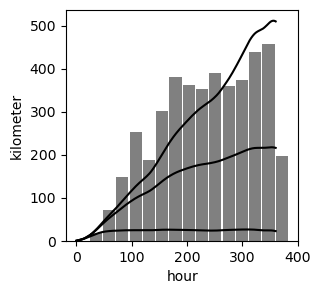

In [415]:
fig, ax= plt.subplots(figsize=(3,3))

plt.bar(DS.t.values, DS.length.values, width=22, align='edge', color='gray')


# X_ip  = xp_over_time_iter(Vi, t, dHdt, Hi = 1 * units('m'))
# X_zip = xp_over_time_iter(Vi, t, np.full(len(dHdt), 0)*units('m/hour'), Hi = 1 * units('m'))

# T = 360 # hours

# Vi = np.full(T, 20*0.03) * units('m/s')
# t = np.arange(T) * units('hour')
# Fi = np.full(T, dHdt) * dHdt.units

Fi = dHdt

X_ip  = xp_over_time_iter(Vi, t, Fi, Hi = 0.1 * units('m'))
X_hip = xp_over_time_iter(Vi, t, 0.1*Fi, Hi = 0.1 * units('m'))
X_zip = xp_over_time_iter(Vi, t, np.full(len(Fi), 0)*units('m/hour'), Hi = 0.1 * units('m'))



# Fi = 0.0001 * units('cm/hour') # ice production rate
plt.plot(t, X_ip, c='k')
plt.plot(t, X_hip, c='k')
plt.plot(t, X_zip, c='k')


In [416]:
np.max(X_ip)

<Quantity(26.1498856, 'kilometer')>

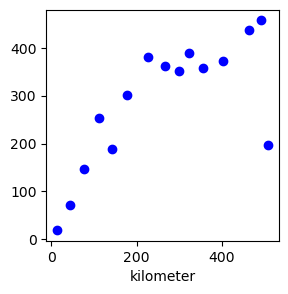

In [407]:
fig,ax=plt.subplots(figsize=(3,3))
# plt.scatter(X_ip[::24], DS.length.values, c='k')
plt.scatter(X_zip[::24], DS.length.values, c='b')


In [380]:
DS

<xarray.Dataset>
Dimensions:               (time: 14, t: 14)
Coordinates:
  * time                  (time) datetime64[ns] 2019-12-07 ... 2019-12-20
  * t                     (t) float64 0.0 24.0 48.0 72.0 ... 264.0 288.0 312.0
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 ...
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...
    length                (time) float64 nan 20.73 60.69 ... 390.0 62.35 nan

In [267]:
np.nanmax(X_ip)

<Quantity(11.9967615, 'kilometer')>